<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/cnn_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.1 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 395MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:46<00:00,  1.03s/it]


epoch: 0, lossD:3.2280493507396826, lossG:21.11108467416856,lossG_fake:15.05735314933999, lossG_real:6.0537314930008455 ,equality:9.003621656339146


evaluate:83.65374755859375,kid_mean:0.03313494101166725, kid_std:0.011007384397089481,kid_:(tensor(0.0331), tensor(0.0110))


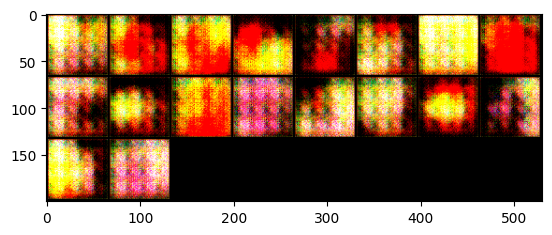

100%|██████████| 103/103 [00:19<00:00,  5.25it/s]


epoch: 1, lossD:1.7694632940500685, lossG:7.397401393038555,lossG_fake:4.368225810597244, lossG_real:3.0291755826583184 ,equality:1.3390502279389258


evaluate:93.5796890258789,kid_mean:0.04498304799199104, kid_std:0.02389802783727646,kid_:(tensor(0.0450), tensor(0.0239))


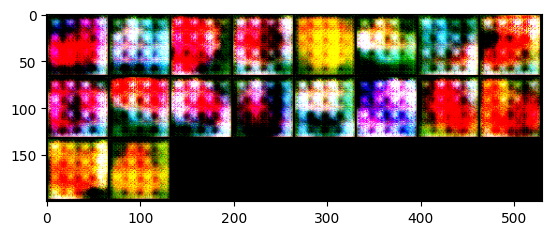

100%|██████████| 103/103 [00:19<00:00,  5.25it/s]


epoch: 2, lossD:1.5344437910515127, lossG:6.917714234694694,lossG_fake:4.083392581314716, lossG_real:2.8343216250243697 ,equality:1.2490709562903466


evaluate:94.35587310791016,kid_mean:0.052406858652830124, kid_std:0.02701309323310852,kid_:(tensor(0.0524), tensor(0.0270))


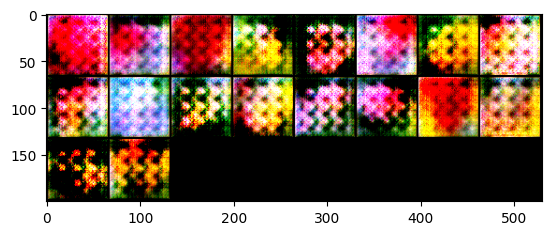

100%|██████████| 103/103 [00:19<00:00,  5.20it/s]


epoch: 3, lossD:1.6815342555925683, lossG:6.149758834283329,lossG_fake:3.6372061238705533, lossG_real:2.512552720829121 ,equality:1.1246534030414321


evaluate:87.057373046875,kid_mean:0.04673174023628235, kid_std:0.02300822176039219,kid_:(tensor(0.0467), tensor(0.0230))


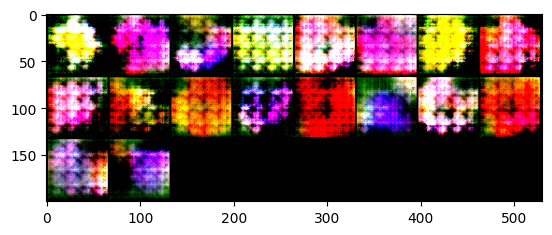

100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


epoch: 4, lossD:1.609024640425895, lossG:5.773501623024061,lossG_fake:3.4222988596240294, lossG_real:2.351202744014055 ,equality:1.0710961156099743


evaluate:99.691162109375,kid_mean:0.061667174100875854, kid_std:0.032251399010419846,kid_:(tensor(0.0617), tensor(0.0323))


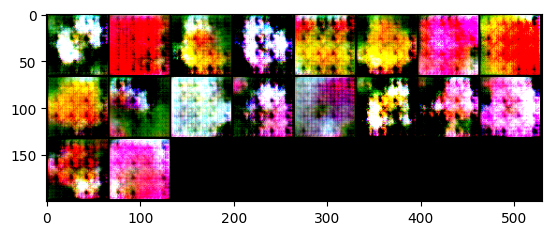

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 5, lossD:1.4116611963915593, lossG:6.081325609707138,lossG_fake:3.534458312594775, lossG_real:2.546867333569573 ,equality:0.9875909790252018


evaluate:100.14524841308594,kid_mean:0.06277816742658615, kid_std:0.030959168449044228,kid_:(tensor(0.0628), tensor(0.0310))


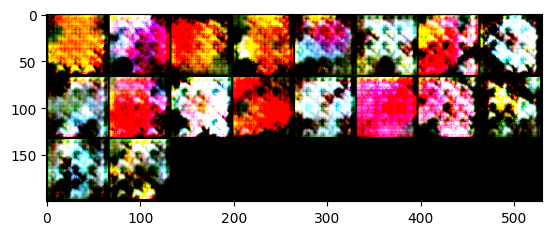

100%|██████████| 103/103 [00:19<00:00,  5.18it/s]


epoch: 6, lossD:1.35666312176047, lossG:6.114239419548257,lossG_fake:3.529779666835822, lossG_real:2.5844597816467285 ,equality:0.9453198851890936


evaluate:96.49852752685547,kid_mean:0.06180664896965027, kid_std:0.03330100700259209,kid_:(tensor(0.0618), tensor(0.0333))


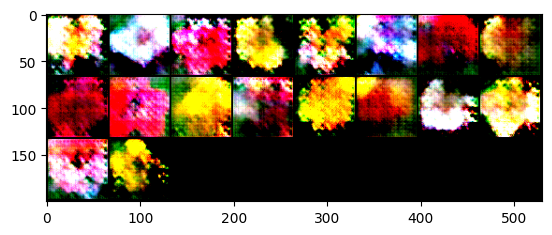

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 7, lossD:1.4478438849588042, lossG:6.1938040418532285,lossG_fake:3.6444011509997174, lossG_real:2.549402889117454 ,equality:1.0949982618822633


evaluate:95.01930236816406,kid_mean:0.059217557311058044, kid_std:0.029454734176397324,kid_:(tensor(0.0592), tensor(0.0295))


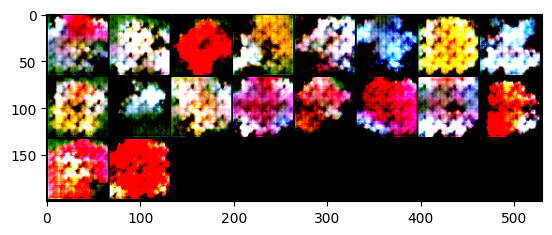

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 8, lossD:1.3308004354967655, lossG:6.404511359131452,lossG_fake:3.79723952464687, lossG_real:2.6072718307231235 ,equality:1.1899676939237467


evaluate:97.25333404541016,kid_mean:0.052193380892276764, kid_std:0.03261006250977516,kid_:(tensor(0.0522), tensor(0.0326))


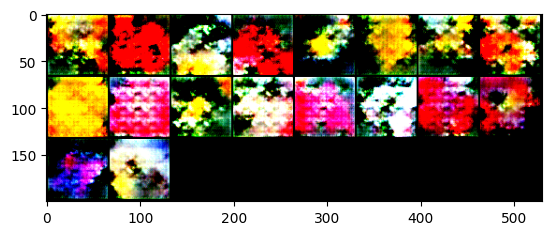

100%|██████████| 103/103 [00:19<00:00,  5.15it/s]


epoch: 9, lossD:1.3744851055654508, lossG:6.19708323710173,lossG_fake:3.6744548904085623, lossG_real:2.5226283330940507 ,equality:1.1518265573145117


evaluate:100.06965637207031,kid_mean:0.056698981672525406, kid_std:0.03262073174118996,kid_:(tensor(0.0567), tensor(0.0326))


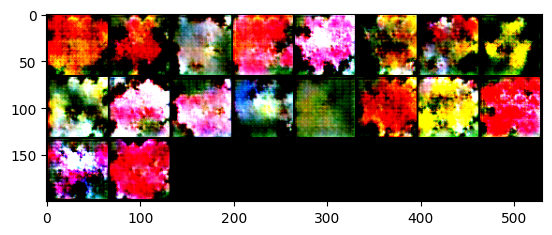

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 10, lossD:1.3835212113787827, lossG:5.973692079192227,lossG_fake:3.498002316766572, lossG_real:2.4756897601109107 ,equality:1.0223125566556615


evaluate:105.31401824951172,kid_mean:0.0641963928937912, kid_std:0.03364968299865723,kid_:(tensor(0.0642), tensor(0.0336))


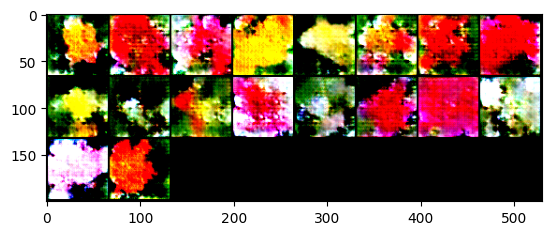

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 11, lossD:1.3892827711059053, lossG:5.803164213606455,lossG_fake:3.391312157066123, lossG_real:2.4118520432305566 ,equality:0.9794601138355663


evaluate:104.84840393066406,kid_mean:0.0573837086558342, kid_std:0.03313814848661423,kid_:(tensor(0.0574), tensor(0.0331))


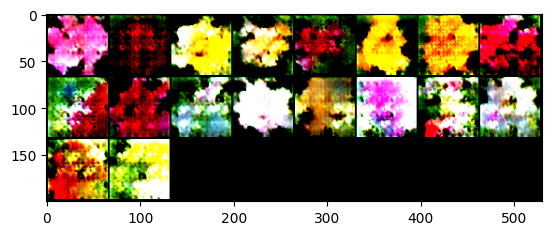

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 12, lossD:1.2917439208447354, lossG:5.918953252070159,lossG_fake:3.414887005843005, lossG_real:2.5040662494099255 ,equality:0.9108207564330795


evaluate:99.68299102783203,kid_mean:0.06806762516498566, kid_std:0.03693918511271477,kid_:(tensor(0.0681), tensor(0.0369))


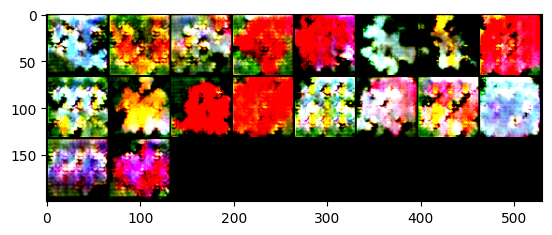

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 13, lossD:1.3216356617733114, lossG:5.952978939686007,lossG_fake:3.374087649062999, lossG_real:2.578891283678777 ,equality:0.7951963653842222


evaluate:99.78147888183594,kid_mean:0.07221794128417969, kid_std:0.03908362239599228,kid_:(tensor(0.0722), tensor(0.0391))


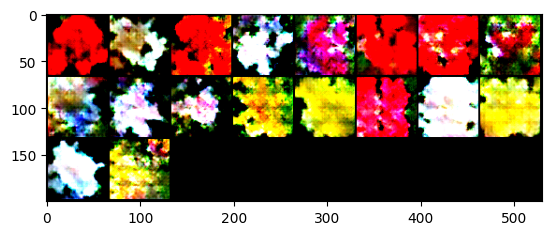

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 14, lossD:1.239795811257316, lossG:6.102499915558157,lossG_fake:3.511895517701084, lossG_real:2.590604387440728 ,equality:0.9212911302603564


evaluate:97.29688262939453,kid_mean:0.0713411420583725, kid_std:0.034763313829898834,kid_:(tensor(0.0713), tensor(0.0348))


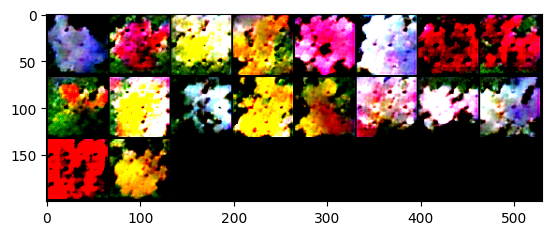

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 15, lossD:1.2766311330702698, lossG:6.178728612881263,lossG_fake:3.473185666556497, lossG_real:2.7055429440100216 ,equality:0.7676427225464755


evaluate:95.32909393310547,kid_mean:0.06634904444217682, kid_std:0.04471961036324501,kid_:(tensor(0.0663), tensor(0.0447))


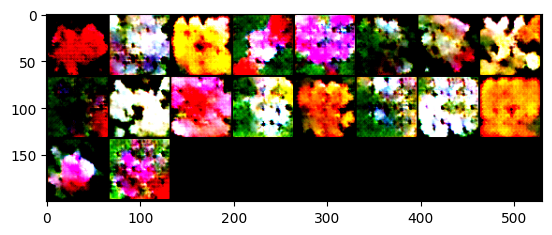

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 16, lossD:1.259504389415667, lossG:6.198124617048838,lossG_fake:3.587510865868874, lossG_real:2.6106137424996754 ,equality:0.9768971233691985


evaluate:92.80172729492188,kid_mean:0.06767401844263077, kid_std:0.03546851500868797,kid_:(tensor(0.0677), tensor(0.0355))


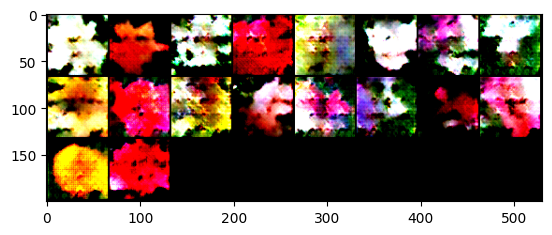

100%|██████████| 103/103 [00:20<00:00,  5.15it/s]


epoch: 17, lossD:1.271021549562806, lossG:5.9749107777493675,lossG_fake:3.363301829805652, lossG_real:2.611608947943715 ,equality:0.7516928818619371


evaluate:92.02099609375,kid_mean:0.06564152240753174, kid_std:0.04075543209910393,kid_:(tensor(0.0656), tensor(0.0408))


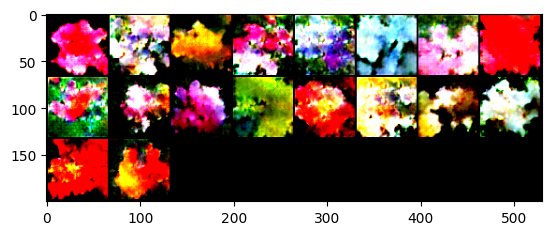

100%|██████████| 103/103 [00:19<00:00,  5.15it/s]


epoch: 18, lossD:1.2330474797093753, lossG:6.107192456143574,lossG_fake:3.4462422167213216, lossG_real:2.6609502365288225 ,equality:0.7852919801924991


evaluate:91.24949645996094,kid_mean:0.06544355303049088, kid_std:0.0385618731379509,kid_:(tensor(0.0654), tensor(0.0386))


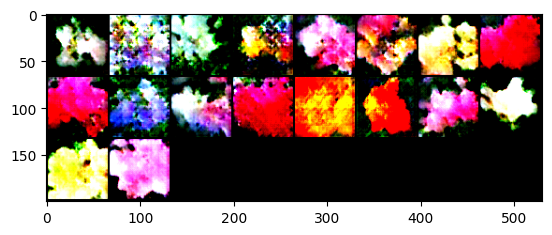

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 19, lossD:1.1800400441132703, lossG:6.095306405743349,lossG_fake:3.447704883455073, lossG_real:2.6476015436996536 ,equality:0.8001033397554194


evaluate:92.66384887695312,kid_mean:0.06590186059474945, kid_std:0.03857121244072914,kid_:(tensor(0.0659), tensor(0.0386))


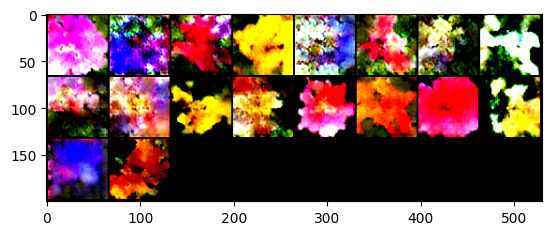

100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


epoch: 20, lossD:1.2584512742977698, lossG:5.948843187498815,lossG_fake:3.3496797883394853, lossG_real:2.599163428093623 ,equality:0.7505163602458622


evaluate:90.79619598388672,kid_mean:0.06702163070440292, kid_std:0.03218526393175125,kid_:(tensor(0.0670), tensor(0.0322))


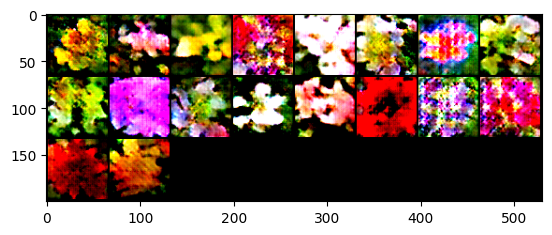

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 21, lossD:1.1005581796747967, lossG:6.1977747991247085,lossG_fake:3.4125387060989456, lossG_real:2.7852360912897054 ,equality:0.6273026148092402


evaluate:87.84352111816406,kid_mean:0.06407583504915237, kid_std:0.03699732944369316,kid_:(tensor(0.0641), tensor(0.0370))


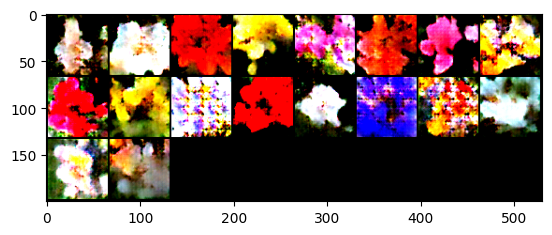

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 22, lossD:1.159095598077311, lossG:6.363766850777043,lossG_fake:3.611228372286824, lossG_real:2.7525385045310826 ,equality:0.8586898677557415


evaluate:90.07657623291016,kid_mean:0.0607200488448143, kid_std:0.03516137972474098,kid_:(tensor(0.0607), tensor(0.0352))


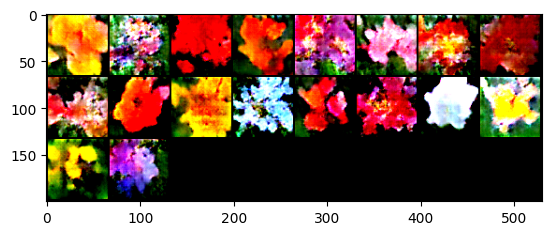

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 23, lossD:1.0872116048359177, lossG:6.398646771329121,lossG_fake:3.615686102978234, lossG_real:2.78296067066563 ,equality:0.8327254323126043


evaluate:91.59783935546875,kid_mean:0.06729816645383835, kid_std:0.041079118847846985,kid_:(tensor(0.0673), tensor(0.0411))


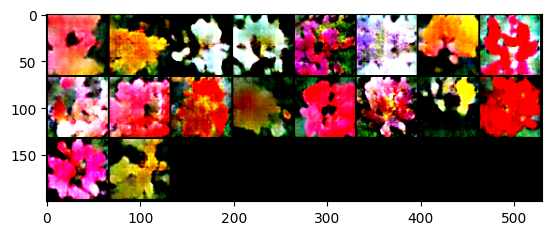

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 24, lossD:1.0958508203909234, lossG:6.605099691928012,lossG_fake:3.7019699464723903, lossG_real:2.9031297359073047 ,equality:0.7988402105650856


evaluate:92.51541137695312,kid_mean:0.07060611993074417, kid_std:0.04407995194196701,kid_:(tensor(0.0706), tensor(0.0441))


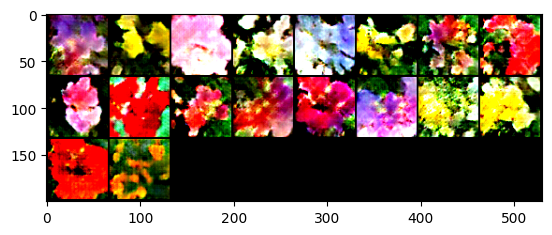

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 25, lossD:1.1558757557452304, lossG:6.469917056629959,lossG_fake:3.6411462345169587, lossG_real:2.8287708281892017 ,equality:0.8123754063277571


evaluate:92.71356201171875,kid_mean:0.06542608141899109, kid_std:0.03994309529662132,kid_:(tensor(0.0654), tensor(0.0399))


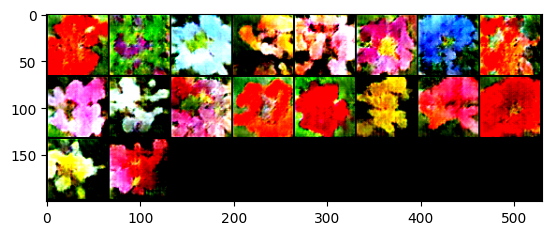

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 26, lossD:1.0460350854882916, lossG:6.498710868428055,lossG_fake:3.5985911824170826, lossG_real:2.9001196825388567 ,equality:0.698471499878226


evaluate:95.11724853515625,kid_mean:0.06738536804914474, kid_std:0.03883347287774086,kid_:(tensor(0.0674), tensor(0.0388))


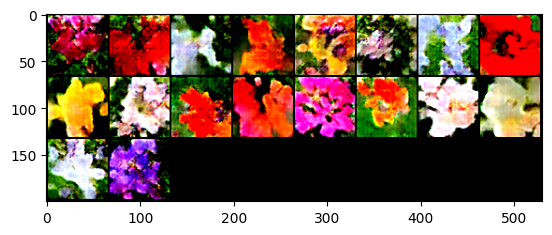

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 27, lossD:1.15183619402566, lossG:6.392271301121387,lossG_fake:3.553173941605299, lossG_real:2.8390973574906875 ,equality:0.7140765841146117


evaluate:93.82276153564453,kid_mean:0.06409209966659546, kid_std:0.03817222639918327,kid_:(tensor(0.0641), tensor(0.0382))


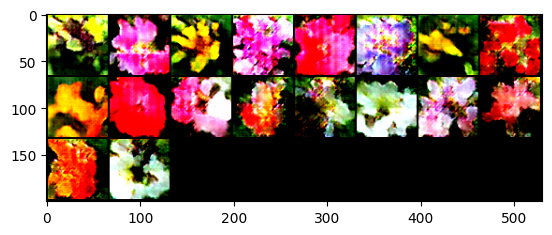

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 28, lossD:1.0096529393809512, lossG:6.955716679397138,lossG_fake:3.9573120075522117, lossG_real:2.9984046857333877 ,equality:0.958907321818824


evaluate:91.48123931884766,kid_mean:0.06344940513372421, kid_std:0.03699622303247452,kid_:(tensor(0.0634), tensor(0.0370))


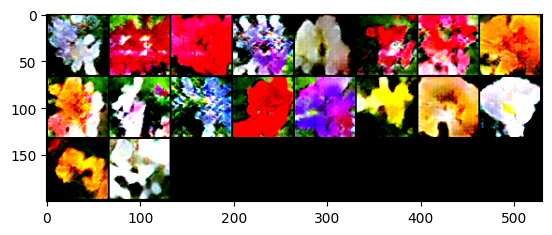

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 29, lossD:1.0478926072421584, lossG:6.736642485683404,lossG_fake:3.7741417421877963, lossG_real:2.9625007585414407 ,equality:0.8116409836463556


evaluate:92.63216400146484,kid_mean:0.06709029525518417, kid_std:0.03124835342168808,kid_:(tensor(0.0671), tensor(0.0312))


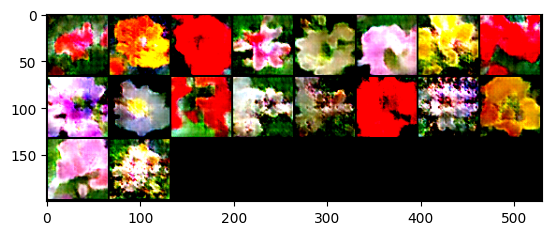

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 30, lossD:1.0609597149983192, lossG:6.7485175179046335,lossG_fake:3.7088543622239123, lossG_real:3.0396631579954647 ,equality:0.6691912042284476


evaluate:91.6070327758789,kid_mean:0.0742463618516922, kid_std:0.04303302243351936,kid_:(tensor(0.0742), tensor(0.0430))


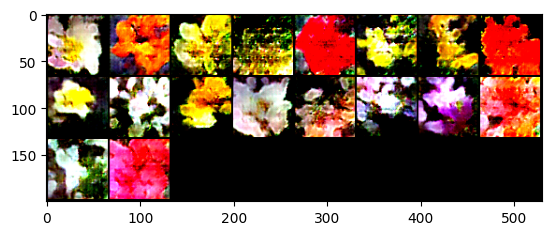

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 31, lossD:0.8887895301563068, lossG:7.16295141849703,lossG_fake:3.9902699051551447, lossG_real:3.1726815266516604 ,equality:0.8175883785034843


evaluate:93.66938781738281,kid_mean:0.06607522815465927, kid_std:0.04058156907558441,kid_:(tensor(0.0661), tensor(0.0406))


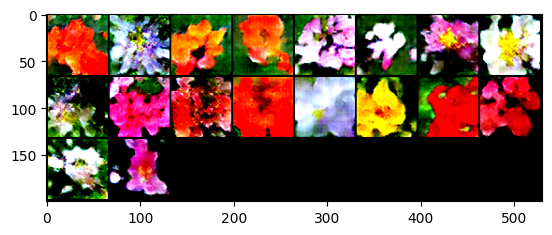

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 32, lossD:1.0695052858695244, lossG:6.658455015386193,lossG_fake:3.7259750834946495, lossG_real:2.932479938835774 ,equality:0.7934951446588756


evaluate:93.3423843383789,kid_mean:0.0585024394094944, kid_std:0.03533193841576576,kid_:(tensor(0.0585), tensor(0.0353))


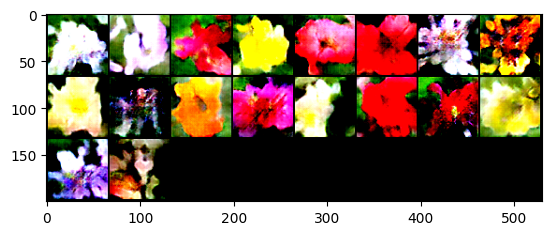

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 33, lossD:0.9423854964450725, lossG:7.098870726465021,lossG_fake:3.9972603436812615, lossG_real:3.1016103908853623 ,equality:0.8956499527958992


evaluate:92.8722915649414,kid_mean:0.05643216148018837, kid_std:0.03340446576476097,kid_:(tensor(0.0564), tensor(0.0334))


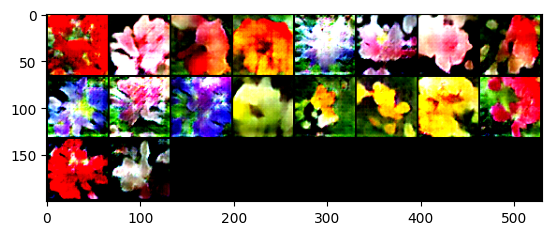

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 34, lossD:0.8778088803140862, lossG:7.434252743582124,lossG_fake:4.208856640510189, lossG_real:3.225396082239244 ,equality:0.983460558270945


evaluate:93.56766510009766,kid_mean:0.058716583997011185, kid_std:0.034912560135126114,kid_:(tensor(0.0587), tensor(0.0349))


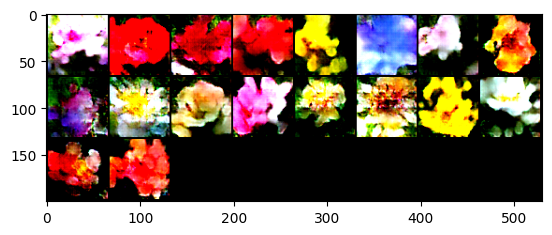

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 35, lossD:0.9283810305653266, lossG:7.157275232296546,lossG_fake:3.9522991973219566, lossG_real:3.204976054071223 ,equality:0.7473231432507337


evaluate:92.4797134399414,kid_mean:0.06180088222026825, kid_std:0.03482774645090103,kid_:(tensor(0.0618), tensor(0.0348))


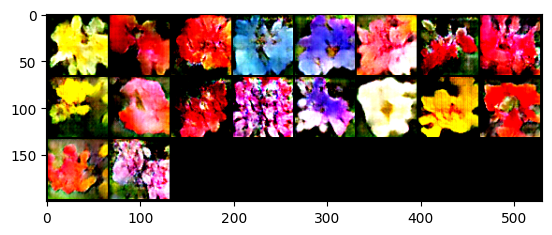

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 36, lossD:0.8365641438845292, lossG:7.34517190062884,lossG_fake:4.0909184217453, lossG_real:3.2542534375075 ,equality:0.8366649842378004


evaluate:92.21131896972656,kid_mean:0.06603800505399704, kid_std:0.03960900381207466,kid_:(tensor(0.0660), tensor(0.0396))


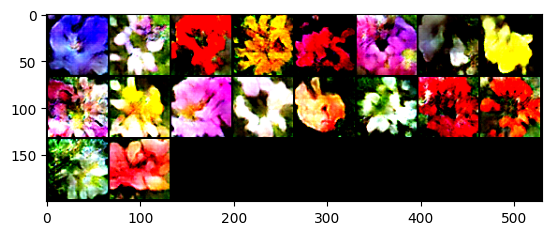

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 37, lossD:0.8671907219782616, lossG:7.5144379532452925,lossG_fake:4.211440485657998, lossG_real:3.3029974560135775 ,equality:0.9084430296444204


evaluate:92.18648529052734,kid_mean:0.06297408044338226, kid_std:0.03758704289793968,kid_:(tensor(0.0630), tensor(0.0376))


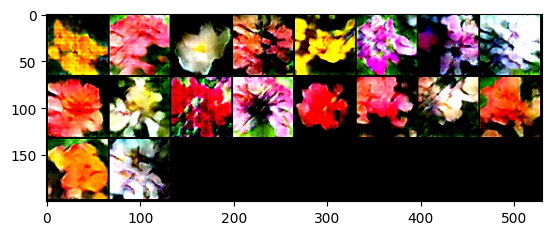

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 38, lossD:0.845486599264793, lossG:7.406306988984635,lossG_fake:4.189177199474816, lossG_real:3.2171298250990006 ,equality:0.9720473743758156


evaluate:92.32147216796875,kid_mean:0.06447694450616837, kid_std:0.038320232182741165,kid_:(tensor(0.0645), tensor(0.0383))


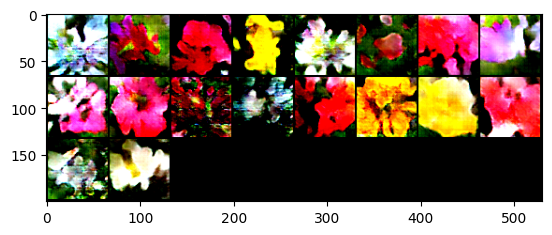

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 39, lossD:0.9060305258602772, lossG:7.5015759931027315,lossG_fake:4.1495868881929265, lossG_real:3.351989132397383 ,equality:0.7975977557955436


evaluate:93.27033996582031,kid_mean:0.06092377007007599, kid_std:0.03419138863682747,kid_:(tensor(0.0609), tensor(0.0342))


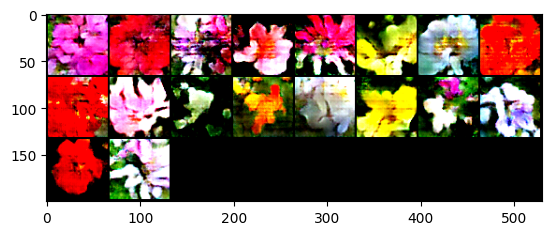

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 40, lossD:0.7832795790966275, lossG:7.580374051066278,lossG_fake:4.188692282704474, lossG_real:3.391681784565009 ,equality:0.7970104981394646


evaluate:94.43231964111328,kid_mean:0.05885002017021179, kid_std:0.028552120551466942,kid_:(tensor(0.0589), tensor(0.0286))


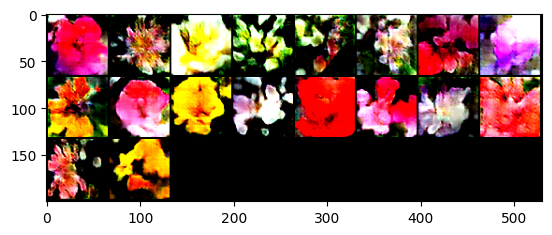

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 41, lossD:0.9231555200028188, lossG:7.458434169732251,lossG_fake:4.115700838056583, lossG_real:3.342733336883841 ,equality:0.7729675011727415


evaluate:94.34638977050781,kid_mean:0.06475188583135605, kid_std:0.032802335917949677,kid_:(tensor(0.0648), tensor(0.0328))


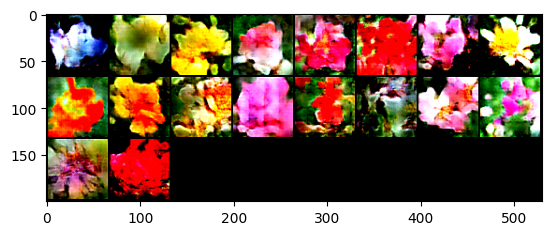

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 42, lossD:0.9422069307669853, lossG:7.176820278167725,lossG_fake:3.9459664914214496, lossG_real:3.230853769385699 ,equality:0.7151127220357507


evaluate:96.1659927368164,kid_mean:0.06267800182104111, kid_std:0.03603463992476463,kid_:(tensor(0.0627), tensor(0.0360))


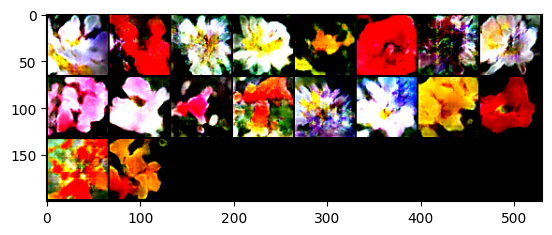

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 43, lossD:0.8104681123807592, lossG:7.547828734499737,lossG_fake:4.151321930792725, lossG_real:3.3965068592608554 ,equality:0.7548150715318696


evaluate:97.06498718261719,kid_mean:0.07098186761140823, kid_std:0.03648034483194351,kid_:(tensor(0.0710), tensor(0.0365))


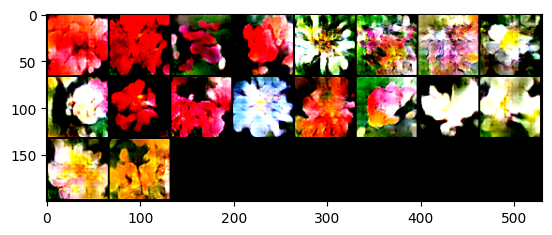

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 44, lossD:0.8201293402794495, lossG:7.584856459237997,lossG_fake:4.150471897090523, lossG_real:3.4343845633048455 ,equality:0.7160873337856777


evaluate:99.01728820800781,kid_mean:0.06511731445789337, kid_std:0.03554998338222504,kid_:(tensor(0.0651), tensor(0.0355))


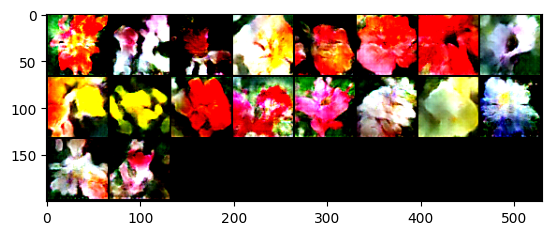

100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


epoch: 45, lossD:0.7942816182536986, lossG:7.377332979035609,lossG_fake:4.000628558177392, lossG_real:3.376704428959819 ,equality:0.6239241292175732


evaluate:98.98165893554688,kid_mean:0.06733796745538712, kid_std:0.04488637298345566,kid_:(tensor(0.0673), tensor(0.0449))


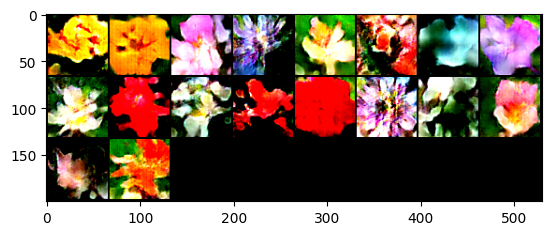

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 46, lossD:0.8544139049006897, lossG:7.831044081345345,lossG_fake:4.3021528683241135, lossG_real:3.5288911884270826 ,equality:0.7732616798970309


evaluate:99.98236083984375,kid_mean:0.06948065012693405, kid_std:0.04386041313409805,kid_:(tensor(0.0695), tensor(0.0439))


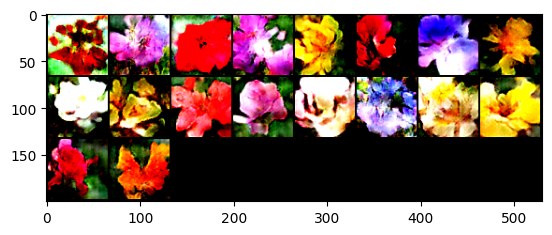

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 47, lossD:0.7096733176013799, lossG:7.695716445885815,lossG_fake:4.247422491462485, lossG_real:3.4482939301185236 ,equality:0.7991285613439616


evaluate:100.25739288330078,kid_mean:0.0742276981472969, kid_std:0.037198178470134735,kid_:(tensor(0.0742), tensor(0.0372))


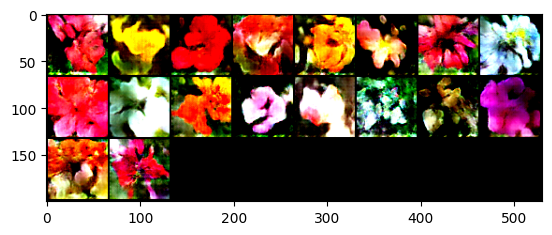

100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


epoch: 48, lossD:0.7069278458513103, lossG:7.850778862110619,lossG_fake:4.2057351412125, lossG_real:3.6450437191620613 ,equality:0.5606914220504389


evaluate:100.08967590332031,kid_mean:0.06590460985898972, kid_std:0.03870067372918129,kid_:(tensor(0.0659), tensor(0.0387))


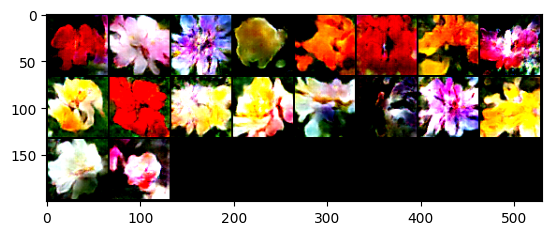

100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


epoch: 49, lossD:0.6777855902186876, lossG:8.020329318000275,lossG_fake:4.345334388677356, lossG_real:3.674994922957374 ,equality:0.6703394657199824


evaluate:100.02664184570312,kid_mean:0.06768887490034103, kid_std:0.042834438383579254,kid_:(tensor(0.0677), tensor(0.0428))


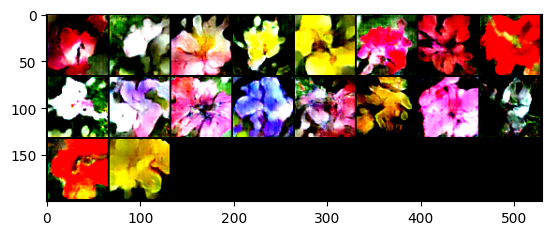

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

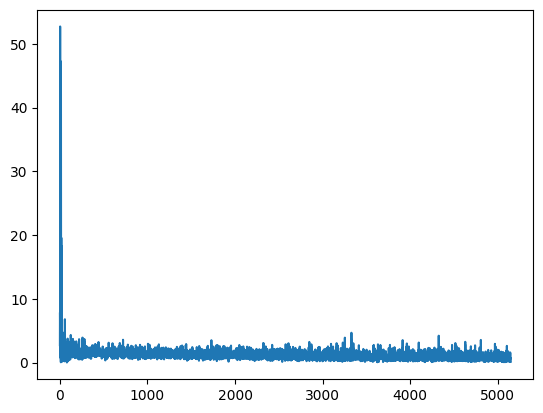

In [45]:
plt.plot(raw_lossesD)

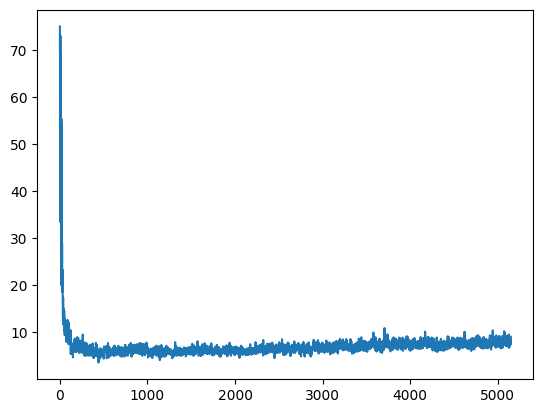

In [46]:
plt.plot(raw_lossesG)

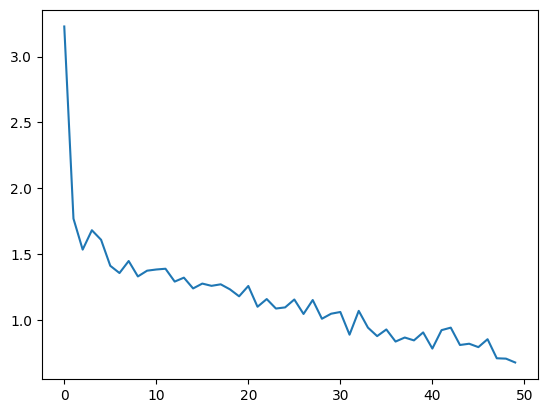

In [47]:
plt.plot(lossesD)

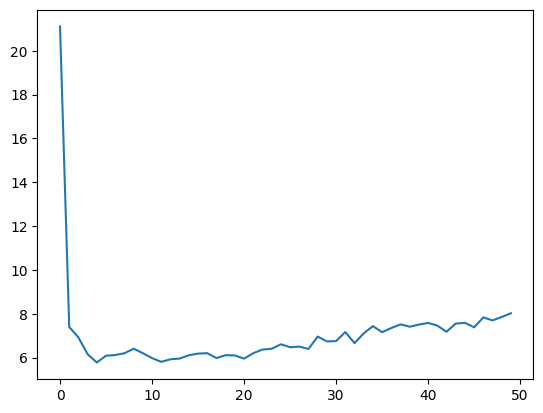

In [48]:
plt.plot(lossesG)

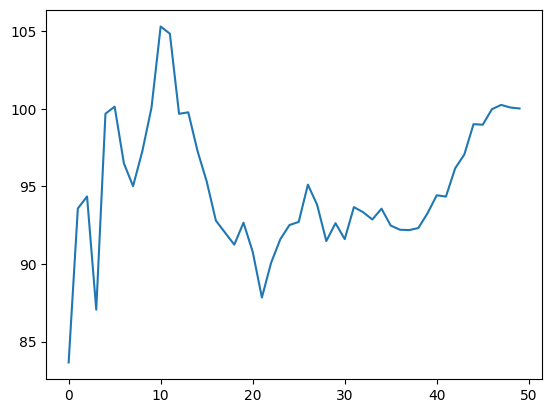

In [49]:
plt.plot(fid_)

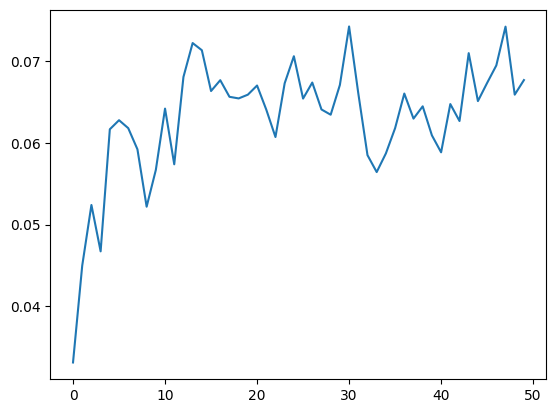

In [50]:
plt.plot(kid_mean_)

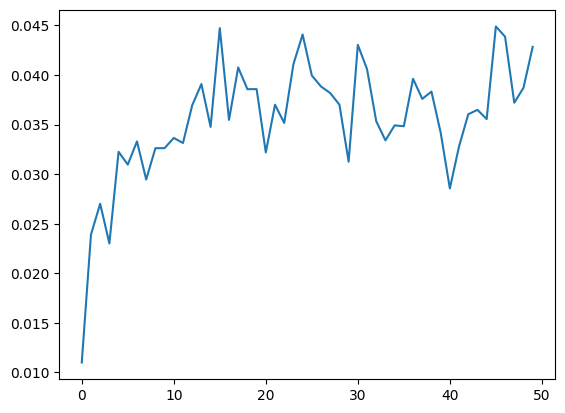

In [51]:
plt.plot(kid_std_)

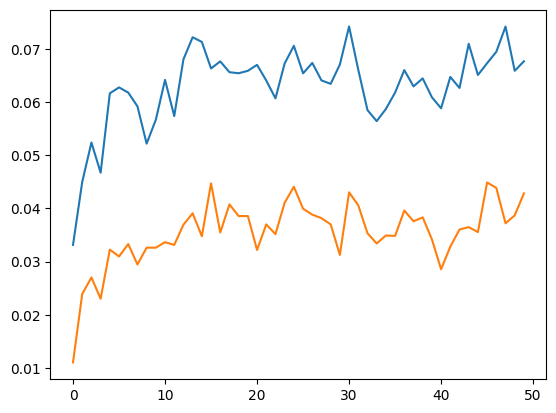

In [52]:
plt.plot(kid_score)

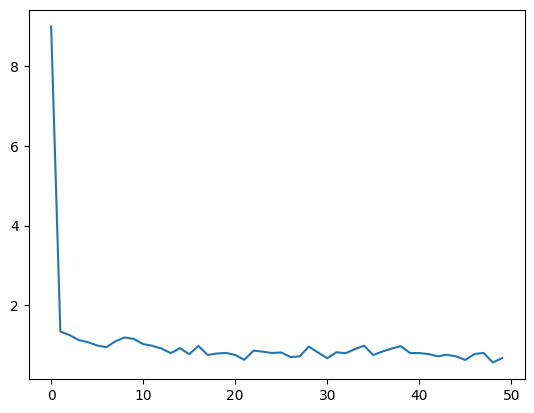

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0671), tensor(0.0434))